<a href="https://colab.research.google.com/github/drshahizan/Python-big-data/blob/main/assignment/ass6/hpdp/NoBumper/assignment6_big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Mastering Big Data Handling
## Group: NO BUMPER

## Group Member:
<table>
  <tr>
    <th>Name</th>
    <th>Matric Number</th>
  </tr>
  <tr>
    <th>NG ZI XING</th>
    <th>A21EC0213</th>
  </tr>
  <tr>
    <th>LOO ZHI YUAN</th>
    <th>A21EC0197</th>
  </tr>
</table>

Date of Submission: 17/12/2023


## 1. Pick a Big Dataset

In this assignment 6, we have choose a dataset called "New York City Bus Data" from [Kaggle](https://www.kaggle.com/). In this dataset, it's suitable for the assignment 6 as it consider as a big data(over 700 MB). The dataset is having 1 GB size in compressed format(.zip) and up to 5GB in .csv format. The "New York City Bus Data" is a dataset that collecting all the data streams available from variable bus companies around the world and found MTA in NYC which is more reliable.

The dataset contains 4 dataset which is "mta_1706.csv", "mta_1708.csv", "mta_1710.csv" and "mta_1712.csv" that represents June 2017, August 2017, October 2017 and December 2017 respectively.

Source:
https://www.kaggle.com/datasets/stoney71/new-york-city-transport-statistics?select=mta_1706.csv

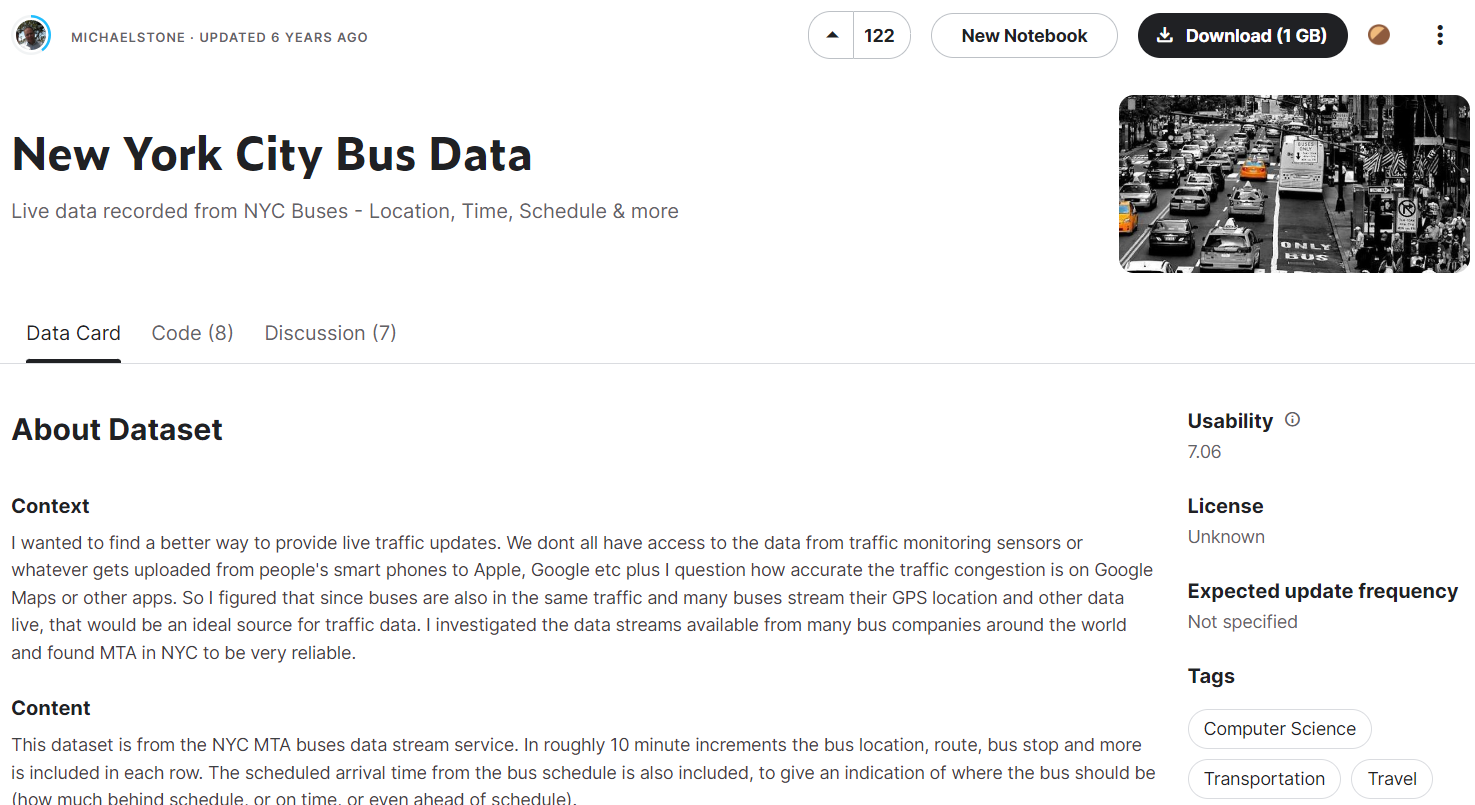

To compare the effectiveness of traditional approach like using pandas only between the technique of big data processing like using sampling, Dask and more in the context of memory and computational cost, this notebook is divided into two seperate portion which is the traditional approach and big data strategics. Three data analysis problem is proposed and using both approach on the problem to show the difference between them. In this notebook, five main big data strategics which is loading less data, chunking, optimize data type, sampling, Dask will be utilized.

## 2. Loading the Dataset and Preparation

### 2.1. Install and Import Necessary Library/Tool

We will install and import some necessary libraries and tool such as pandas, numpy, dask and more to perform five smart strategies to handle large datasets and conduct a comprehensive comparative analysis between traditional methods and advanced strategies.



In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.array as da
from google.colab import files
from dask.distributed import Client
import os
import re
import dask
from memory_profiler import memory_usage

%load_ext memory_profiler

In [ ]:
!pip install dask_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 4.9 MB/s eta 0:00:00


Based on the code below, we will download the dataset directly from kaggle and unzip the dataset. At first, we will upload the "*kaggle.json*" file which is the API token of Kaggle. Therefore, we can download the dataset directly from the original source of Kaggle.

In [ ]:
files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d stoney71/new-york-city-transport-statistics

Saving kaggle.json to kaggle.json
100% 1.30G/1.30G [01:00<00:00, 26.1MB/s]
100% 1.30G/1.30G [01:00<00:00, 23.2MB/s]


Then, we will unzip the downloaded dataset that come in zip file format.

In [ ]:
!unzip /content/new-york-city-transport-statistics.zip

Archive:  /content/new-york-city-transport-statistics.zip
  inflating: mta_1706.csv            
  inflating: mta_1708.csv            
  inflating: mta_1710.csv            
  inflating: mta_1712.csv            


### 2.2. Data Preparation

The original dataset consist of some problems that lead to unable read by the conventional pd.read_csv, thus we have to do some correction to the data before read them by using pd.read_csv. Some of the row in the original dataset has additional "," in the cell value lead to the wrong splitting, because the pd.read_csv is using "," as separator which will lead to inconsistent number of columns.

In [ ]:
#find out the additional "," and replace it with space
def correct_column(filename):


  with open("correct_"+filename, "w") as wf:

    with open(filename) as f:

      line = f.readline()
      while line:
        if len(line.split(",")) > 17:
          pos1, pos2 = re.search(r"\(.*(,).*\)",line).span(1) #detect the index of additional ","
          line = line[:pos1]+ " " + line[pos2:] #replace with space

        wf.write(line) #rewrite into a new file
        line = f.readline()


In [ ]:
filenames = [ "mta_1706.csv", "mta_1708.csv", "mta_1710.csv", "mta_1712.csv" ]

for filename in filenames:
  correct_column(filename)

In [ ]:
for filename in filenames:
  os.remove(filename)

In [ ]:
filenames = [ "mta_1706.csv", "mta_1708.csv", "mta_1710.csv", "mta_1712.csv" ]
filenames = [ "correct_" + filename for filename in filenames]

At last, the dataset that gone through data preparation will be renamed such as "*correct_mta_1706.csv*". Then, it will be able to use to perform comparative analysis.

## 3. Comparative Analysis

### 3.1. Traditional Approach

#### 3.1.1. What is the range of distance from stop that Arrival Proximity Text represent?

By grouping the Arrival Proximity Text againts the distance from stop by using lower bound and upper bound function as aggregating method. The lower bound function is defined as mean minus 1.5 times of standard deviation(std) and upper bound is defined as mean plus 1.5 times of standard deviation(std), the range between the lower an upper bound is the solution.

In [ ]:
%%time

%memit  data = pd.concat( [ pd.read_csv(filename) for filename in filenames], ignore_index = True )

peak memory: 9661.84 MiB, increment: 9425.12 MiB
CPU times: user 1min 36s, sys: 20.6 s, total: 1min 56s
Wall time: 2min 14s


The operation above took **2 minutes 14 seconds** and the memory usage up to **9425.12 MB**.

In [ ]:
def lower_bound(x):

  return x.mean() - 1.5 * x.std()

def upper_bound(x):

  return x.mean() + 1.5 * x.std()

In [ ]:
%%time

range_proximity = data[["ArrivalProximityText", "DistanceFromStop"]].groupby("ArrivalProximityText").agg( { "DistanceFromStop": [lower_bound, upper_bound] } ).sort_values(("DistanceFromStop", "lower_bound"))

CPU times: user 8.28 s, sys: 7.08 s, total: 15.4 s
Wall time: 15.4 s


In [ ]:
%memit data[["ArrivalProximityText", "DistanceFromStop"]].groupby("ArrivalProximityText").agg( { "DistanceFromStop": [lower_bound, upper_bound] } ).sort_values(("DistanceFromStop", "lower_bound"))

peak memory: 7413.06 MiB, increment: 1214.25 MiB


The operation above took **15.4 seconds** and the memory usage up to **1214.25 MB**.

The "*%%time*" is a command that will print the CPU and wall clock times of the operation. Hence, we can observe and compare the time consumed of each operation and approach.

In [ ]:
range_proximity

DistanceFromStop              
                          lower_bound   upper_bound
ArrivalProximityText                               
at stop                     -3.015718     22.763060
approaching                 31.765322    137.174342
< 1 stop away               78.604677    501.961427
1 stop away                103.315202    410.371605
2 stops away               314.000000    314.000000
...                               ...           ...
20.7 miles away          33247.975105  33385.085501
20.8 miles away          33396.394000  33550.507961
20.9 miles away          33579.479011  33613.927965
22.3 miles away          35849.547846  35964.452154
22.2 miles away                   NaN           NaN

[212 rows x 2 columns]

Based on the output of "*range_proximity*" above, "*lower_bound*" represent the closest distance of the bus from stop and "*upper_bound*" represent the furthest distance of the bus from stop according to the "*ArrivalProximityText*".

From the operation above, we can observe that we load the only two columns is needed for this question from the whole dataset which still occupies and consume quite large of memory and this operation is taking around **15.4 seconds**.

#### 3.1.2. What is the time difference betwen expected Arrival Time and Scheduled Arrival Time?

The Scheduled Arrival Time is in wrong format, so we have to transform them before convert them into datetime format by using correct_date function

Based on the code below, we will read the first 10 rows of the "*ScheduledArrivalTime*" from the dataset to observe and understand the format of "*ScheduledArrivalTime*".

In [ ]:
data["ScheduledArrivalTime"].head(10)

0    24:06:14
1    23:58:02
2    24:00:53
3    24:03:00
4    23:59:38
5    24:02:35
6    24:08:00
7    23:58:47
8    24:00:00
9    24:01:14
Name: ScheduledArrivalTime, dtype: object

According to the "*correct_date(x)*" function below, it will use input dictionary "*x*" that associated with the "*ExpectedArrivalTime*" and "*ScheduledArrivalTime*" keys and assigned them to "*ex*" and "*sc*" variables.

In details, the code wil check missing value and replace it with "NaN". Then, it will process the times and return them in a corrected date and time format.

In [ ]:
def correct_date(x):

  ex, sc = x["ExpectedArrivalTime"], x["ScheduledArrivalTime"]

  if pd.isna(ex) or pd.isna(sc) :
    return np.NaN

  if int(sc[:2]) >= 24:
    time = str( int(sc[:2]) - 24 ) + sc[2:]
    day = ex.strftime("%Y-%m-%d")
  else:
    time = sc
    day = (ex - pd.to_timedelta("1 days")).strftime("%Y-%m-%d")

  return day + " " + time


In [ ]:
%%time

data["ExpectedArrivalTime"] = pd.to_datetime(data["ExpectedArrivalTime"])
data["ScheduledArrivalTime"] = data[["ExpectedArrivalTime", "ScheduledArrivalTime"]].apply(correct_date, axis = 1) #transform to appropriate format
data["ScheduledArrivalTime"] = pd.to_datetime(data["ScheduledArrivalTime"])
data["TimeDifference"] = ( data["ScheduledArrivalTime"] - data["ExpectedArrivalTime"]  ).dt.total_seconds() # get time difference

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


The "*%%time*" is a command that will print the CPU and wall clock times of the operation. Hence, we can observe and compare the time consumed of each operation and approach.

The memory usage is exploding from 6.7GB to over 12GB which causing the **crashed of the system**. Hence, the big data strategics are needed to solve this problem.

#### 3.1.3. How to predict origin name from origin latitude and longitude?

 The code is below performing categorical encoding by replacing the categorical values in the "*OriginName*" column into numerical values format. Then, the unique values are stored in the variable "*unique*".

In [ ]:
%%time

%memit data["OriginName"], unique = data["OriginName"].factorize()

peak memory: 6429.20 MiB, increment: 405.50 MiB
CPU times: user 4.42 s, sys: 608 ms, total: 5.02 s
Wall time: 5.31 s


The operation above took **5.31 seconds** and the memory usage up to **405.50 MB**.

Then, remove the rows that contain missing values by performing the code below.

In [ ]:
%%time
data.dropna(axis = 0, inplace = True)

CPU times: user 39.9 s, sys: 7.06 s, total: 46.9 s
Wall time: 47.4 s


The operation above took **47.4 seconds**.

The code below creates a dictionary which is "*index_to_name*" that will iterate over the enumerated values in the "*unique*". Then, delete the "*unique*" array from the memory.

In [ ]:
index_to_name = { i: u  for i,u  in enumerate(unique) }

del unique

As a way to deal with imbalanced dataset, we will use decision tree from sklearn as shown below to adjust the weights of the classes automatically to make sure it can fit the data.

In [ ]:
#use decision tree to fit the data

from sklearn.tree import DecisionTreeClassifier

cls = DecisionTreeClassifier(class_weight = "balanced")

The "*%%time*" shown below is a command that will print the CPU and wall clock times of the operation. Hence, we can observe and compare the time consumed of each operation and approach.

In [ ]:
%%time

%memit cls.fit(data[["OriginLat", "OriginLong"]], data["OriginName"])

peak memory: 7144.92 MiB, increment: 1514.93 MiB
CPU times: user 3min 56s, sys: 1.63 s, total: 3min 58s
Wall time: 4min 7s


The operation above took **4 minutes 7 seconds** and the memory usage up to **1514.93 MB**.

In [ ]:
# get the score of data
test = data[["OriginLat", "OriginLong", "OriginName"]].sample(frac = 0.001)
cls.score(test[["OriginLat", "OriginLong"]], test["OriginName"])

0.9877606527651859

Noted that we use very small portion of data to score, because it will lead to crashed if large fraction is used. That problem can be solved in the next part.

The "*del*" will help to delete or clear the memory of the dataframe.

In [ ]:
del data

### 3.2. Big Data Strategies

In this section, we will utilize the big data strategics, mostly is benifit from the ability of Dask to complete again the three question above. Then, evaluate their performance in memory utilize and computational cost to see the improvement.

In [ ]:
# The Dask enable us to divide the local cluster into number of workers that can work in parallezing

client = Client(n_workers = 2, threads_per_worker = 4)
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42211
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42823'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34481'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45533', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45533
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:59936
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:40861', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40861
INFO:distributed.core:Sta

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42211,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:45533,Total threads: 4
Dashboard: http://127.0.0.1:45609/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:42823,


#### 3.2.1. What is the range of distance from stop that Arrival Proximity Text represent?

For this question, we will apply three smart strategies to handle the large datasets effectively.

Strategies for Big Datasets:

1. Load Less Data
2. Use Chunking
3. Parallelize with Dask

The code below will load specific columns which are "*ArrivalProximityText*" and "*DistanceFromStop*" from the CSV files we imported before into the Dask DataFrame. Hence, we will load lesser data.

Other than that, we will specify the data types for the specified columns to optimise the memory usage and avoid the usage of large datatype that will cause wastage. Then, we will load the data in chunks of 256 MB each for the better parallelization.

In [ ]:
#we load less data by loading only the columns that will be used to anwser our question
use_cols = ["ArrivalProximityText", "DistanceFromStop"]
dtype = [str, np.float32] #specify the datatype for each column to avoid large datatype lead to waste
dtype = { i:j for i,j in zip(use_cols, dtype)}

#we use chunking at here where each chunks is 256 MB
ddf = dd.read_csv(os.path.join("*.csv"), blocksize = "256MB" , usecols = use_cols, dtype = dtype  )

In [ ]:
%%time

%memit ddf = client.persist(ddf) #submit the task graph asynchronously to load the data into ram

peak memory: 252.38 MiB, increment: 0.98 MiB
CPU times: user 203 ms, sys: 26.9 ms, total: 230 ms
Wall time: 507 ms


The operation above took **507 milliseconds** and the memory usage up to **0.98 MB**.

In [ ]:
ddf.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26522430 entries, 0 to 1288730
Data columns (total 2 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ArrivalProximityText  object 
 1   DistanceFromStop      float32
dtypes: float32(1), object(1)
memory usage: 505.9+ MB


In [ ]:
# create a running recipe
std = ddf.groupby("ArrivalProximityText").std()
mean = ddf.groupby("ArrivalProximityText").mean()

lower_bound = mean - 1.5*std
upper_bound = mean + 1.5*std

The "%%time" shown below is a command that will print the CPU and wall clock times of the operation. Hence, we can observe and compare the time consumed of each operation and approach.

In [ ]:
#compute the lower bound and upper bound
#may need to wait a while before running this cell, because the data is loading in the background

%%time

%memit lower_bound, upper_bound = dd.compute(lower_bound, upper_bound)
pd.concat({ "lower_bound" : lower_bound, "upper_bound" : upper_bound}, axis = 1 ).sort_values(("lower_bound", "DistanceFromStop"))

peak memory: 268.02 MiB, increment: 1.38 MiB
CPU times: user 1.11 s, sys: 169 ms, total: 1.28 s
Wall time: 15.7 s


,lower_bound,upper_bound
,DistanceFromStop,DistanceFromStop
ArrivalProximityText,,
at stop,-3.015719,22.763060
approaching,31.765296,137.174363
< 1 stop away,78.604732,501.961395
1 stop away,103.315214,410.371592
2 stops away,314.000000,314.000000
...,...,...
20.7 miles away,33250.200675,33382.859931
20.8 miles away,33395.552947,33551.349013


We can see the computational time is bigger than the convetional pandas operation due to the scheduling overhead, but the memory usage is significantly dropped. In the conventional method, the whole dataset is loaded into memory and our memory in RAM reach 6.7GB. But for dask, after loading data finish, the memory in ram back to 1.5GB immediately.

Apart from that, the time consumed is **15.7 seconds** which is very close to the traditional approch but this only consumed **1.38 MB** of memory.

#### 3.2.2. What is the time difference betwen expected Arrival Time and Scheduled Arrival Time?

For this question, we will apply four smart strategies to handle the large datasets effectively.

Strategies for Big Datasets:

1. Optimize Data Type
2. Parallelize with Dask
3. Chunking
4. Load Less Data


By performing the code below, we will restarting the Dask client and clear the state of the Dask client before going through the next question.

In [ ]:
client.restart()

INFO:distributed.scheduler:Restarting workers and releasing all keys.
INFO:distributed.nanny:Nanny asking worker to close. Reason: scheduler-restart
INFO:distributed.nanny:Nanny asking worker to close. Reason: scheduler-restart
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:48236; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:44095', name: 0, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1702796532.6701095')
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:48246; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:42061', name: 1, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1702796532.6809483')
INFO:distributed.scheduler:Lost all workers
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43625', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute strea

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35901,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: 3 minutes ago,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:37587,Total threads: 4
Dashboard: http://127.0.0.1:41309/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:46319,


The code below will load specific columns which are "*ExpectedArrivalTime*" and "*ScheduledArrivalTime*" from the CSV files we imported before into the Dask DataFrame. Hence, we will load lesser data.

Other than that, we will specify the data types for the specified columns to optimise the memory usage and avoid the usage of large datatype that will cause wastage. Then, we will load the data in chunks of 256 MB each for the better parallelization.

In [ ]:
#we load less data by loading only the columns that will be used to anwser our question
use_cols = ["ExpectedArrivalTime", "ScheduledArrivalTime"]

#we use chunking at here where each chunks is 256 MB
ddf = dd.read_csv(os.path.join("*.csv"),
                  blocksize = "256MB" ,
                  usecols = use_cols,
                  parse_dates = [0], dtype = {"ScheduledArrivalTime" : str}  ) #use appropriate datetime datatype

In [ ]:
ddf = client.persist(ddf)

The code below will help to return a processed and corrected date and time. It will also handle the missing values.

In [ ]:
def correct_date(x):

  ex, sc = x["ExpectedArrivalTime"], x["ScheduledArrivalTime"]

  if pd.isna(ex) or pd.isna(sc) :
    return np.NaN

  if int(sc[:2]) >= 24:
    time = str( int(sc[:2]) - 24 ) + sc[2:]
    day = ex.strftime("%Y-%m-%d")
  else:
    time = sc
    day = (ex - pd.to_timedelta("1 days")).strftime("%Y-%m-%d")

  return day + " " + time


In [ ]:
#prepare the processing recipe

#transform to appropriate format
ScheduledArrivalTime = ddf.map_partitions(lambda x : x.apply(correct_date, axis = 1), meta= pd.Series(dtype = str))

#change the datetype to datetime
ScheduledArrivalTime = ScheduledArrivalTime.map_partitions(pd.to_datetime, meta = pd.Series(dtype = "datetime64[ns]"))

#get the time difference
TimeDifference = ScheduledArrivalTime - ddf["ExpectedArrivalTime"]

#transform into seconds
TimeDifference = TimeDifference.map_partitions( lambda x: x.dt.total_seconds()  )

By performing the code below, Dask will generate a visualization of the computation graph for the "*TimeDifference*". Thus, we can understand the computation process visually.

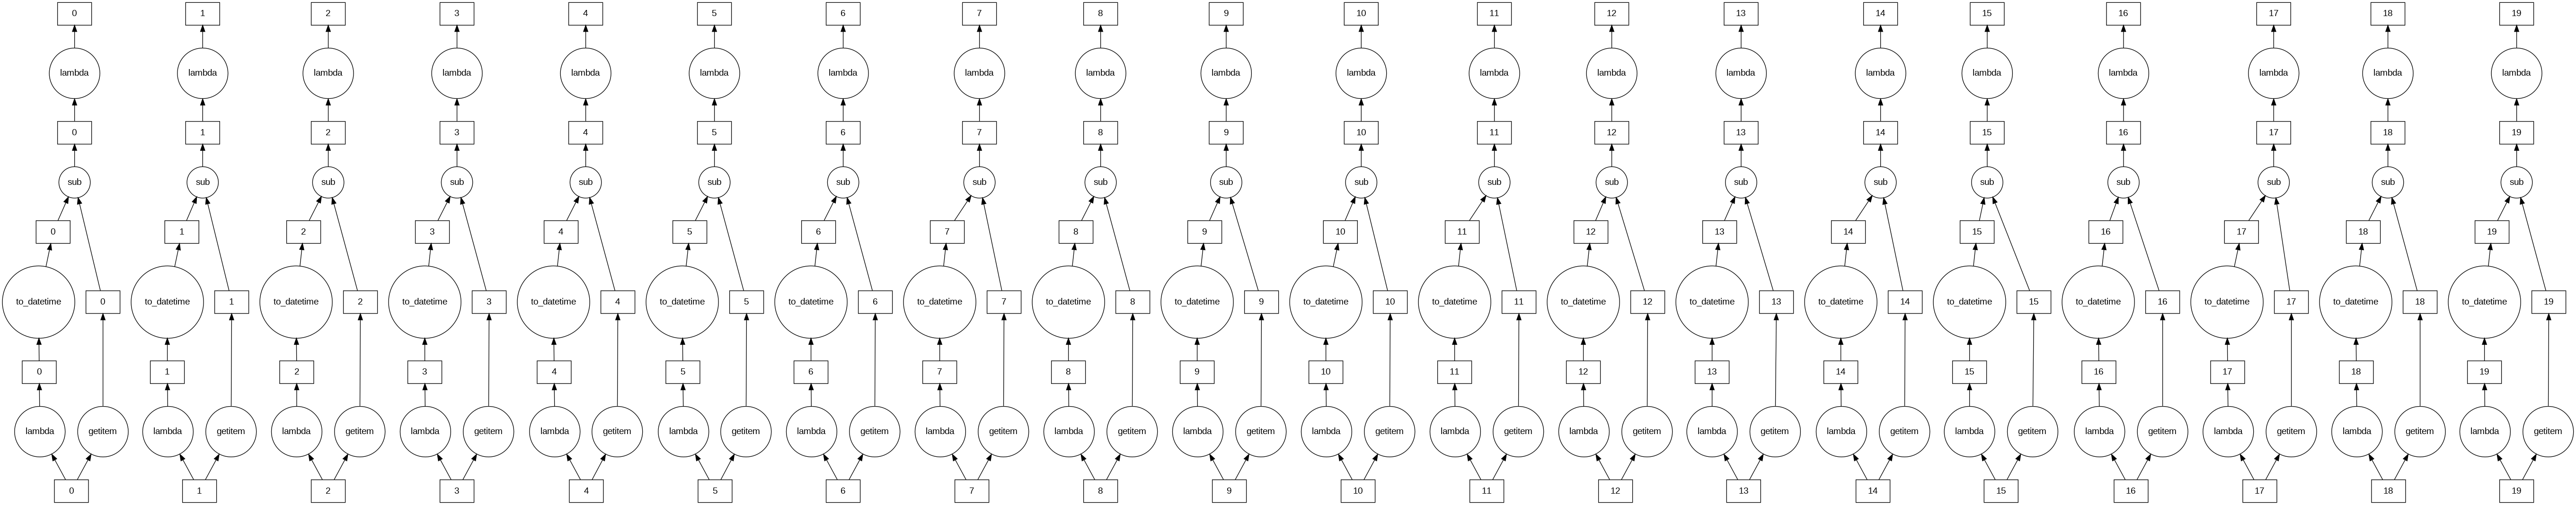

In [ ]:
TimeDifference.visualize()

The "%%time" shown below is a command that will print the CPU and wall clock times of the operation. Hence, we can observe and compare the time consumed of each operation and approach.

In [ ]:
%%time
#run the recipe defined

%memit TimeDifference.compute()

peak memory: 1017.73 MiB, increment: 721.38 MiB
CPU times: user 1min 18s, sys: 11.9 s, total: 1min 30s
Wall time: 20min 54s


The operation above took **20 minutes 54 seconds** and the memory usage up to **721.38 MB**.

Finally, we have no crashed in this problem because we use chunking to load the data chunks that can fit into the memory and we use parallerize technique which is map_partitions to each of the chunks which accerelate the computational time to **19 minutes 8 seconds**.

#### 3.2.3. How to predict origin name from origin latitude and longitude?

For this question, we will apply five smart strategies to handle the large datasets effectively.

Strategies for Big Datasets:

1. Sampling
2. Chunking
3. Parallerizing with Dask
4. Load Less Data
5. Optimize Data Types

By performing the code below, we will restarting the Dask client and clear the state of the Dask client before going through the next question.

In [ ]:
client.restart()

INFO:distributed.scheduler:Restarting workers and releasing all keys.
INFO:distributed.nanny:Nanny asking worker to close. Reason: scheduler-restart
INFO:distributed.nanny:Nanny asking worker to close. Reason: scheduler-restart
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:53372; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:34851', name: 1, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1702087164.7087133')
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:53360; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:41659', name: 0, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1702087164.7349675')
INFO:distributed.scheduler:Lost all workers
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:46137', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute strea

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 12.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45131,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 12.68 GiB
Comm: tcp://127.0.0.1:46137,Total threads: 4
Dashboard: http://127.0.0.1:38003/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:35959,


The code below will load specific columns which are "*OriginLong*", "*OriginLat*" and "*OriginName*" from the CSV files we imported before into the Dask DataFrame. Hence, we will load lesser data.

Other than that, we will specify the data types for the specified columns to optimise the memory usage and avoid the usage of large datatype that will cause wastage. Then, we will load the data in chunks of 256 MB each for the better parallelization.

In [ ]:
#we load less data by loading only the columns that will be used to anwser our question
use_cols = ["OriginLong", "OriginLat", "OriginName"]
dtype = { col : dty for col, dty in zip(use_cols, [np.float64, np.float64, str]) }

#we use chunking at here where each chunks is 256 MB
ddf = dd.read_csv(os.path.join("*.csv"),
                  blocksize = "256MB" ,
                  usecols = use_cols,
                  dtype = dtype  ) #use appropriate  datatype

In [ ]:
ddf = client.persist(ddf)

For code below, we can retrieve the futures associated with the Dask DataFrame "*ddf*" in a Dask. By running the code, we can observe the status for the operation before and wait until all the operations finished to continue.

In [ ]:
#wait until all finished
client.futures_of(ddf)

[<Future: finished, type: pandas.core.frame.DataFrame, key: ('read-csv-1efb43c2172cc9bf7847d5e851973258', 0)>,
 <Future: finished, type: pandas.core.frame.DataFrame, key: ('read-csv-1efb43c2172cc9bf7847d5e851973258', 1)>,
 <Future: finished, type: pandas.core.frame.DataFrame, key: ('read-csv-1efb43c2172cc9bf7847d5e851973258', 2)>,
 <Future: finished, type: pandas.core.frame.DataFrame, key: ('read-csv-1efb43c2172cc9bf7847d5e851973258', 3)>,
 <Future: finished, type: pandas.core.frame.DataFrame, key: ('read-csv-1efb43c2172cc9bf7847d5e851973258', 4)>,
 <Future: finished, type: pandas.core.frame.DataFrame, key: ('read-csv-1efb43c2172cc9bf7847d5e851973258', 5)>,
 <Future: finished, type: pandas.core.frame.DataFrame, key: ('read-csv-1efb43c2172cc9bf7847d5e851973258', 6)>,
 <Future: finished, type: pandas.core.frame.DataFrame, key: ('read-csv-1efb43c2172cc9bf7847d5e851973258', 7)>,
 <Future: finished, type: pandas.core.frame.DataFrame, key: ('read-csv-1efb43c2172cc9bf7847d5e851973258', 8)>,
 

The code is performing the data cleaning process by dropping the "NaN" values and repartitioning the DataFrame.

The "%%time" shown below is a command that will print the CPU and wall clock times of the operation. Hence, we can observe and compare the time consumed of each operation and approach.

In [ ]:
%%time

ddf = ddf.map_partitions( lambda x : x.dropna(axis = 0) )
ddf = ddf.repartition(1).reset_index().repartition(20).persist()

X = ddf[["OriginLat", "OriginLong"]]
Y = ddf.repartition(1).map_partitions( lambda x : pd.Series(x["OriginName"].factorize()[0])).repartition(20)

CPU times: user 31.9 ms, sys: 1.7 ms, total: 33.6 ms
Wall time: 52.3 ms


The operation above took **52.3 milliseconds**.

Based on the code below, we will apply sampling strategy which only take 50% of the data to train the model.

In [ ]:
from dask_ml.model_selection import train_test_split

#sampling, we only take 50% of data to train our model
X_train, X_test, y_train, y_test = train_test_split( X, Y, random_state = 0, test_size = 0.5)

/usr/local/lib/python3.10/dist-packages/dask_ml/model_selection/_split.py:462: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [ ]:
%%time
%memit X_train = X_train.compute()
%memit y_train = y_train.compute()

peak memory: 882.66 MiB, increment: 594.57 MiB
peak memory: 1076.43 MiB, increment: 490.03 MiB
CPU times: user 2.02 s, sys: 1.91 s, total: 3.93 s
Wall time: 19.1 s


The operation above took **19.1 seconds** and the memory usage up to **594.57 MB** and **490.03 MB** for "*x_train*" and "*y_train*" respectively.

As a way to deal with imbalanced dataset, we will use decision tree from sklearn as shown below to adjust the weights of the classes automatically to make sure it can fit the data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

cls = DecisionTreeClassifier(class_weight = "balanced")

The "%%time" shown below is a command that will print the CPU and wall clock times of the operation. Hence, we can observe and compare the time consumed of each operation and approach.

In [ ]:
%%time

%memit cls.fit(X_train, y_train )

peak memory: 1782.05 MiB, increment: 816.16 MiB
CPU times: user 7min 32s, sys: 4.78 s, total: 7min 37s
Wall time: 7min 31s


The operation above took **7 minutes 31 seconds** and the memory usage up to **816.16 MB**.

The code below will divide or repartitioned the "*test_set*" into 100 chunks to avoid crashing.

In [ ]:
# divide the test_set into 100 chunks, otherwise crash will happen

test_set = dd.concat([X_test, y_test.rename("OriginName")], axis = 1).repartition(100).persist()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/multi.py:1297: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


In [ ]:
# get the score of data by using map_partition

def score(x):

  return cls.score(x[["OriginLat", "OriginLong"]], x["OriginName"] )

def aggregate(x):

  return x.mean()

test_score = test_set.reduction(
    lambda x : score(x),
    aggregate = aggregate
    )

In [ ]:
test_score.compute()

0.9916448907234439

Even though we only use 50% of data to train the model, but the accuracy still persist which save more memory and computational cost. Other than that, with conventional approach, we cannot score with large test set, now by applying chunking or partitioning, we can do that.

### 3.3. Memory Usage

Comparison of Memory Usage between Traditional Approach and Big Data Strategies:

The operations and scenarios that handle under traditional approach are mostly have greater memory usage than the big data strategies. In addition, there is an operation in traditional approach causing the system to crash as the memory usage is consuming more than 12 GB. Notably, there is no crashing happened in big data strategies.


### 3.4. Computation Time

Comparison of Computation Time between Traditional Approach and Big Data Strategies:

In general, the big data strategies have the lower computation time compared to traditional approch. In big data strategies, the computation time can goes as low as milliseconds. While in traditional approach, there is a crashing happened causing no computation time recorded and most of the computation time is way higher than the big data strategies.

### 3.5. File Size

The file size is not suitable to compare in this comparative analysis.

## 4. Conclusion

**Why did we chose these strategies?**

In assignment 6, we have choose the five smart strategies below to handle the large datasets effectively compared to the traditional approach.

Load Less Data:

By loading lesser data from the big dataset such as the specific columns that needed for the analysis, we are able to avoid wastage of data which help us to reduce the memory usage and computation time.

Use Chunking:

By applying chunking to the data required, we are able to process the data in smaller size block by block (256 MB) which can avoid a lot of memory problems and issues.

Optimize Data Types:

We will optimize the data types by specifed each data types in more details which ensure there is no large data types that causing memory wastage.

Sampling:

By applying sampling strategies, we will extract the useful and meaningful data from the whole dataset.

Parallelize with Dask:

The powerful function of Dask is helping us to handle and conduct analysis on the big dataset. It making the analysis more memory-efficient.

**Difference Made in Handling Big Data:**

In big data strategies, the strategies applied have made huge differences in handing the big data efficiently and effectively. As we can see from the analysis conducted above, the memory usage is more efficient and the computation time reduced compared to the traditional approach that causing the system crashed.